In [1]:
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout


data = []

#Cargar los datos con OpenCv
paths = ["/kaggle/input/real-life-violence-situations/new_violence"]

#Mostrar imagen
def imshow(img):
    fig,ax = plt.subplots(1,1,figsize = (5,5))
    ax.imshow(img)
    plt.show()

#agregar las etiquetas de salida dadas las carpetas con su nombre
possible_labels = os.listdir(paths[0])
print(possible_labels)

2024-05-31 14:41:51.654614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 14:41:51.654743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 14:41:51.767555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['non_violence', 'violence']


# Guardando los datos en el array data

In [2]:
for label_int, label_str in enumerate(possible_labels):
       for filename in glob.glob(os.path.join(paths[0],label_str, "*.jpg")):
            img = cv2.imread(filename.replace("\\", "/"))
            if img is not None:  # Verificar si la imagen se ha leído correctamente
                try:
                    resized_img = cv2.resize(img, (320, 320))
                    data.append([label_int, resized_img])
                except Exception as e:
                    print(f"Error resizing image {filename}: {e}")
            else:
                print(f"Warning: Unable to read image {filename} Please check the file path and format.")
print(len(data))

11073


# Insertando los datos (training, validacion y testing) en arrays de numpy 

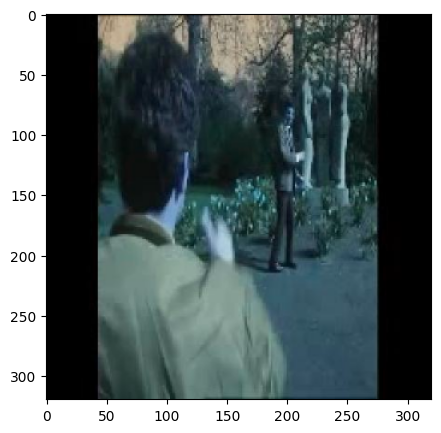

non_violence


In [3]:
#Se Barajea el arreglo data para que no inserte los datos por carpetas
random.Random(0).shuffle(data)

#Se crea arreglos para los conjuntos de validacion, tewsting y entrenamiento
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#Se recorre la lista data para agregar las imagenes a sus correspondientes arreglos
for i,sample in enumerate(data):
    label= sample[0]
    img = sample[1]
    if i <= 0.8*len(data):
        x_train.append(img)
        y_train.append(label)
    elif i >0.8*len(data) and i <= 0.9*len(data):
        x_val.append(img)
        y_val.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

#Convirtiendo los arrays en arreglos de NumPy para Tensorflow
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#Mostrar Imagen en la pos 0
imshow(x_train[0])
print(possible_labels[y_train[0]])

# Convirtiendo las labels de las imagenes en One-Hot Encoding

In [4]:
y_trainOneHot = tf.one_hot(y_train,len(possible_labels))
y_valOneHot = tf.one_hot(y_val,len(possible_labels))
y_testOneHot = tf.one_hot(y_test,len(possible_labels))
print("done")

done


# Definiendo el modelo 

In [5]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def cnn_model():
    model = Sequential()
    model.add(Input(shape=(320, 320, 3)))
    model.add(Convolution2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(len(possible_labels), activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [6]:
model = cnn_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 318, 318, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 157, 157, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 76, 76, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36, 36, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,993,090 (164.01 MB)

 Trainable params: 42,990,594 (164.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

None


# Guardando el proceso automaticamente y configurando Tensorboard

In [7]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_dir = "logs/cnn_logs/train"
os.makedirs(log_dir, exist_ok=True)
checkpoint = ModelCheckpoint('checkpoint/model.{epoch:d}.keras', save_best_only = False, save_freq = "epoch")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq = 1)

print(x_train.shape)

(8859, 320, 320, 3)


# Entrenando el Modelo

In [8]:
model.fit(
    x_train,
    y_trainOneHot,
    epochs = 20,
    batch_size = 64,
    validation_data = (x_val, y_valOneHot),
    callbacks = [tensorboard_callback, checkpoint]
)

Epoch 1/20


2024-05-31 14:43:29.803892: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,32,318,318]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,320,320]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-31 14:43:30.235804: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9337: 4.03405, expected 3.51112
2024-05-31 14:43:30.235907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19344: 4.03405, expected 3.51112
2024-05-31 14:43:30.235957: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29349: 4.03405, expected 3.51112
2024-05-31 14:43:30.236005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Di

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7799 - loss: 2.9071

2024-05-31 14:44:11.718270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 921: 5.8781, expected 5.16091
2024-05-31 14:44:11.718348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2372: 5.67886, expected 4.96167
2024-05-31 14:44:11.718376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3295: 5.5146, expected 4.79741
2024-05-31 14:44:11.718391: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3337: 5.57453, expected 4.85734
2024-05-31 14:44:11.718406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4102: 6.15528, expected 5.43809
2024-05-31 14:44:11.718420: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4520: 5.74603, expected 5.02884
2024-05-31 14:44:11.718434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5207: 6.07665, expected 5.35947
2024-05-31 14:44:11.718450: E externa

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7803 - loss: 2.9047

W0000 00:00:1717166668.119266     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-31 14:44:29.289316: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 505620: 8.34416, expected 7.39305
2024-05-31 14:44:29.289378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 505621: 7.74864, expected 6.79753
2024-05-31 14:44:29.289387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 505622: 7.97717, expected 7.02606
2024-05-31 14:44:29.289395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 505623: 6.95818, expected 6.00707
2024-05-31 14:44:29.289403: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 505624: 7.82683, expected 6.87572
2024-05-31 14:44:29.289411: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 505625: 7.77206, expected 6.82095
2024-05-31 14:44:29.289418: E exter

139/139 ━━━━━━━━━━━━━━━━━━━━ 78s 340ms/step - accuracy: 0.7807 - loss: 2.9023 - val_accuracy: 0.8392 - val_loss: 1.8615
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9148 - loss: 1.5251 - val_accuracy: 0.8762 - val_loss: 1.2497
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9199 - loss: 1.1036 - val_accuracy: 0.8419 - val_loss: 1.3319
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9309 - loss: 0.9037 - val_accuracy: 0.8952 - val_loss: 1.0247
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9391 - loss: 0.8483 - val_accuracy: 0.7191 - val_loss: 1.8171
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.9422 - loss: 0.8203 - val_accuracy: 0.6694 - val_loss: 1.8072
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9437 - loss: 0.7300 - val_accuracy: 0.8238 - val_loss: 1.0385
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 186ms/step - accuracy: 0.9440 - loss: 0.7541 - val

# Prediccion

2024-05-31 14:53:11.268267: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.25329, expected 5.50563
2024-05-31 14:53:11.281876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.06822, expected 5.32056
2024-05-31 14:53:11.281903: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.58897, expected 4.84131
2024-05-31 14:53:11.281917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 5.79339, expected 5.04572
2024-05-31 14:53:11.281928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.19196, expected 5.4443
2024-05-31 14:53:11.281939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18: 6.17255, expected 5.42489
2024-05-31 14:53:11.281950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.11393, expected 5.36627
2024-05-31 14:53:11.281960: E external/local_xla/xla/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


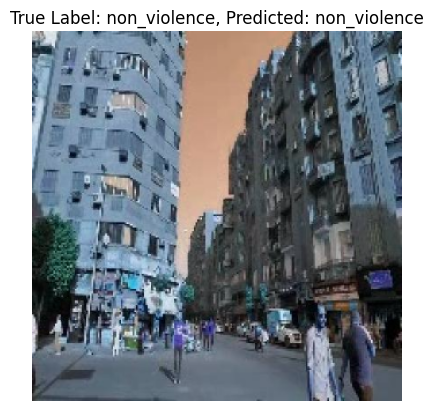

True Label: non_violence
Predicted Label: non_violence


In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que tus datos de prueba están almacenados en x_test y y_test
# Selecciona una imagen aleatoria del conjunto de datos de prueba
random_index = random.randint(0, len(x_test) - 1)
random_image = x_test[random_index]
true_label = y_test[random_index]

# Realiza la predicción
prediction = model.predict(random_image[np.newaxis, ...])
predicted_label = possible_labels[np.argmax(prediction)]

# Muestra la imagen junto con la etiqueta verdadera y la predicción
plt.imshow(random_image)
plt.title(f"True Label: {possible_labels[true_label]}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {possible_labels[true_label]}")
print(f"Predicted Label: {predicted_label}")


In [10]:
model.save('modelViolence.h5')

In [12]:
# Guarda la arquitectura del modelo en JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Guarda los pesos del modelo en HDF5
model.save_weights("model.weights.h5")
